In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G_erdos = nx.erdos_renyi_graph(1000, 0.002)
G_barabasi = nx.barabasi_albert_graph(1000, 1)

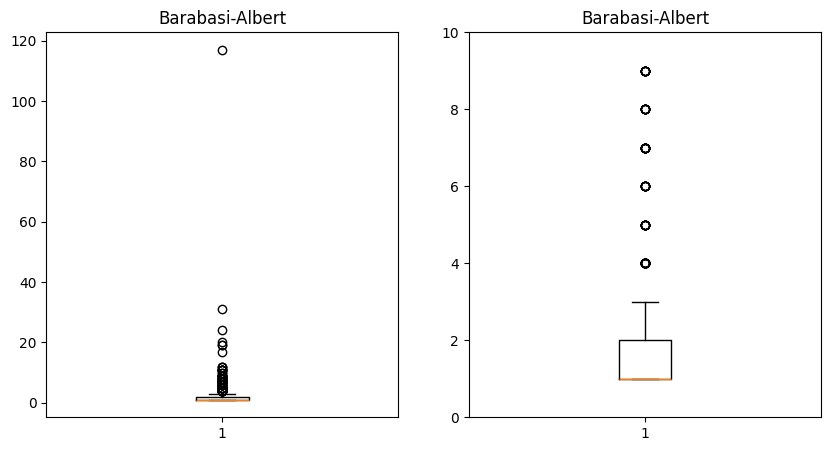

In [35]:
degree_sequence = [d for n, d in G_barabasi.degree()]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.boxplot(degree_sequence)
plt.title('Barabasi-Albert')

degree_sequence = [d for d in degree_sequence if d < 10]
plt.subplot(122)
plt.boxplot(degree_sequence)
plt.ylim(0, 10)
plt.title('Barabasi-Albert')

plt.show()

In [36]:
giant_component_size = max(len(c) for c in nx.connected_components(G_barabasi))
giant_component_size

1000

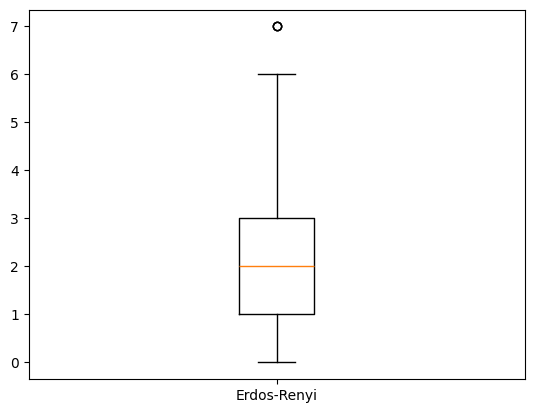

In [21]:
degree_sequence = [d for n, d in G_erdos.degree()]
plt.boxplot([degree_sequence], labels=['Erdos-Renyi'])
plt.show()

In [2]:
import numpy as np

def initialize_sand(G):
    G_degree = dict(G.degree())

    value_dict = {}
    for key, value in G_degree.items():
        if value == 0:
            value_dict[key] = 0
        else:
            random_value = np.random.randint(0, value)
            value_dict[key] = random_value
    
    nx.set_node_attributes(G, value_dict, 'sand')
    return

In [3]:
initialize_sand(G_erdos)
initialize_sand(G_barabasi)

In [9]:
def drop_sand(G, node, depth, visited_nodes = []):
    sand_count = G.nodes[node]['sand']
    node_degree = G.degree[node]

    if node_degree == 0:
        return depth
    
    if len(visited_nodes) == 4 and visited_nodes[0] == visited_nodes[2] and visited_nodes[1] == visited_nodes[3]:
        return depth
    
    if sand_count < node_degree:
        G.nodes[node]['sand'] += 1
    else:
        neighbors = list(G.neighbors(node))
        G.nodes[node]['sand'] = 1  #maybe is 1
        visited_nodes2 = visited_nodes + [node]
        if len(visited_nodes2) > 4:
            visited_nodes2.pop(0)

        for neighbor in neighbors:
            if np.random.rand() < (1/1000):
                continue
            return drop_sand(G, neighbor, depth + 1, visited_nodes2)
    return depth

In [16]:
G_bueno = G_erdos.copy()

avalanche = []
for i in range(10000):
    random_node = np.random.randint(0, G_bueno.number_of_nodes())
    avalanche.append(drop_sand(G_bueno, random_node, 0))

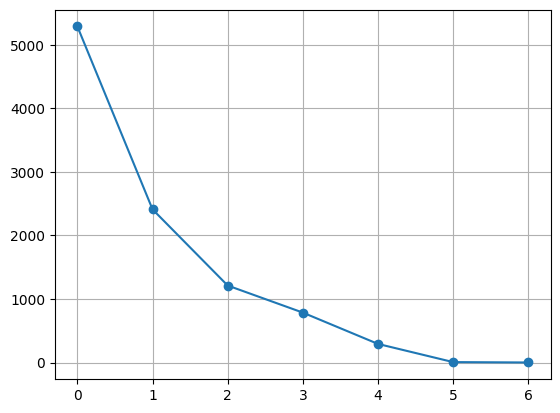

In [17]:
avalanche = np.array(avalanche)
unique, counts = np.unique(avalanche, return_counts=True)

plt.plot(unique, counts, 'o-')
plt.grid()
plt.show()

In [14]:
G_malo = G_barabasi.copy()

avalanche_2 = []
for i in range(10000):
    random_node = np.random.randint(0, G_malo.number_of_nodes())
    avalanche_2.append(drop_sand(G_malo, random_node, 0))

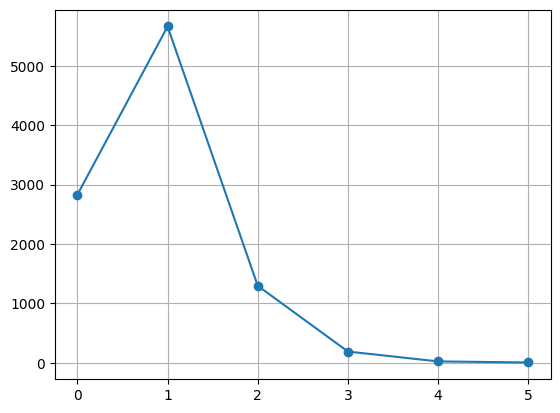

In [15]:
avalanche_2 = np.array(avalanche_2)
unique, counts = np.unique(avalanche_2, return_counts=True)

plt.plot(unique, counts, 'o-')
plt.grid()
plt.show()

## B) Apocalipsis Zombie

En una interaccion zombie-humano:  
* $\alpha$ probabilidad de que el humano se zombifique.  
* $\beta$ probabilidad de que el humano cure al zombie.  
* $1 - \alpha - \beta$ probabilidad de que el humano destruya al zombie.  

Ademas en cada intereraccion el zombie tiene probabilidad $\gamma$ de autodestruirse


$\beta = 0.1$  
Hay que buscar el plano ($\alpha$, $\gamma$)  
Erdos-Renyi, Barabasi, SBM(50 cum).  
5000 Nodos, 4 Grado promedio.  
$\gamma = 0.0005$ recomendado.  

In [10]:
import numpy as np
import networkx as nx
from tqdm.auto import tqdm
import pandas as pd

In [11]:
G_erdos = nx.erdos_renyi_graph(5000, 0.0008)
G_barabasi = nx.barabasi_albert_graph(5000, 2)

In [12]:
state = {}
for x in range(5000):
    #np.random.seed(0)
    state_random = np.random.random()
    if state_random < 0.05:
        state[x] = 'zombie'
    else:
        state[x] = 'human'

In [13]:
nx.set_node_attributes(G_erdos, state, 'state')
nx.set_node_attributes(G_barabasi, state, 'state')

In [14]:
beta = 0.1
alpha = 0.45

gamma = 5e-4

In [15]:
def calculate_state(G):
    human, zombie, dead = 0, 0, 0
    
    for _, d in G.nodes(data=True):
        if d['state'] == 'human':
            human += 1
        elif d['state'] == 'zombie':
            zombie += 1
        else:
            dead += 1

    return human, zombie, dead

def move_element(d, element, source_key, target_key):
    d[target_key].append(element)
    d[source_key].remove(element)
    return

In [16]:
# G = G_barabasi.copy()

# progress_bar = tqdm(
#         range(int(1e4)),
#         desc=f"Simulacion"
#         )

# human_nodes = [n for n, d in G.nodes(data=True) if d['state'] == 'human']
# zombie_nodes = [n for n, d in G.nodes(data=True) if d['state'] == 'zombie']

# nodes_status = {}
# nodes_status['human'] = human_nodes
# nodes_status['zombie'] = zombie_nodes
# nodes_status['dead'] = []

# # convert to function
# for i in progress_bar:

#     if len(nodes_status['human']) == 0 or len(nodes_status['zombie']) == 0:
#         print(f'Quedo la caga en la iteracion: {i}')
#         break

#     for zombie_node in nodes_status['zombie']:
#         random_gamma = np.random.random()
#         if random_gamma < gamma:
#             G.nodes[zombie_node]['state'] = 'dead'
#             move_element(nodes_status, zombie_node, 'zombie', 'dead')
#             continue

#     random_human_node = np.random.choice(nodes_status['human'])
#     zombie_neighbors = [n for n in G.neighbors(random_human_node) if G.nodes[n]['state'] == 'zombie']
#     if len(zombie_neighbors) > 0:
#         interaction_zombie = np.random.choice(zombie_neighbors)

#         random_p = np.random.random()
#         if random_p < alpha: # zombie wins
#             G.nodes[random_human_node]['state'] = 'zombie'
#             move_element(nodes_status, random_human_node, 'human', 'zombie')
#         elif random_p < alpha + beta: # human cure zombie
#             G.nodes[interaction_zombie]['state'] = 'human'
#             move_element(nodes_status, interaction_zombie, 'zombie', 'human')
#         else: # human wins
#             G.nodes[interaction_zombie]['state'] = 'dead'
#             move_element(nodes_status, interaction_zombie, 'zombie', 'dead')

#     #human, zombie, dead = calculate_state(G)

#     progress_bar.set_postfix(
#         human=len(nodes_status['human']),
#         zombie=len(nodes_status['zombie']),
#         dead=len(nodes_status['dead'])
#     )


In [21]:

def simulate_zombie_apocalypse(G, alpha, beta, gamma, n_sim):
    progress_bar = tqdm(
            range(int(1e4)),
            desc=f"Simulacion {n_sim}"
            )

    human_nodes = [n for n, d in G.nodes(data=True) if d['state'] == 'human']
    zombie_nodes = [n for n, d in G.nodes(data=True) if d['state'] == 'zombie']

    nodes_status = {}
    nodes_status['human'] = human_nodes
    nodes_status['zombie'] = zombie_nodes
    nodes_status['dead'] = []

    # convert to function
    for i in progress_bar:

        if len(nodes_status['human']) == 0 or len(nodes_status['zombie']) == 0:
            print(f'Quedo la caga en la iteracion: {i}')
            break

        for zombie_node in nodes_status['zombie']:
            random_gamma = np.random.random()
            if random_gamma < gamma:
                G.nodes[zombie_node]['state'] = 'dead'
                move_element(nodes_status, zombie_node, 'zombie', 'dead')
                continue

        random_human_node = np.random.choice(nodes_status['human'])
        zombie_neighbors = [n for n in G.neighbors(random_human_node) if G.nodes[n]['state'] == 'zombie']
        if len(zombie_neighbors) > 0:
            interaction_zombie = np.random.choice(zombie_neighbors)

            random_p = np.random.random()
            if random_p < alpha: # zombie wins
                G.nodes[random_human_node]['state'] = 'zombie'
                move_element(nodes_status, random_human_node, 'human', 'zombie')
            elif random_p < alpha + beta: # human cure zombie
                G.nodes[interaction_zombie]['state'] = 'human'
                move_element(nodes_status, interaction_zombie, 'zombie', 'human')
            else: # human wins
                G.nodes[interaction_zombie]['state'] = 'dead'
                move_element(nodes_status, interaction_zombie, 'zombie', 'dead')

        #human, zombie, dead = calculate_state(G)

        progress_bar.set_postfix(
            human=len(nodes_status['human']),
            zombie=len(nodes_status['zombie']),
            dead=len(nodes_status['dead'])
        )
    return G

alpha_space = [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
gamma_space = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4]

# save results
results = []

# Make grid search
for alpha in alpha_space:
    for gamma in gamma_space:
        G = G_barabasi.copy()
        G = simulate_zombie_apocalypse(G, alpha, beta, gamma, 1)

        human, zombie, dead = calculate_state(G)
        print(f'Alpha: {alpha}, Gamma: {gamma}, Human: {human}, Zombie: {zombie}, Dead: {dead}')

        # Save results
        results.append({
            'alpha': alpha,
            'gamma': gamma,
            'human': human,
            'zombie': zombie,
            'dead': dead
        })

Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 1e-08, Human: 4444, Zombie: 159, Dead: 397


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 5e-08, Human: 4416, Zombie: 205, Dead: 379


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 1e-07, Human: 4531, Zombie: 126, Dead: 343


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 5e-07, Human: 4465, Zombie: 176, Dead: 359


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 1e-06, Human: 4487, Zombie: 170, Dead: 343


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 5e-06, Human: 4457, Zombie: 184, Dead: 359


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 1e-05, Human: 4443, Zombie: 191, Dead: 366


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 5e-05, Human: 4545, Zombie: 84, Dead: 371


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 0.0001, Human: 4535, Zombie: 61, Dead: 404


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Quedo la caga en la iteracion: 8207
Alpha: 0.45, Gamma: 0.0005, Human: 4645, Zombie: 0, Dead: 355


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 1e-08, Human: 4384, Zombie: 233, Dead: 383


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 5e-08, Human: 4358, Zombie: 261, Dead: 381


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 1e-07, Human: 4332, Zombie: 285, Dead: 383


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 5e-07, Human: 4281, Zombie: 319, Dead: 400


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 1e-06, Human: 4394, Zombie: 228, Dead: 378


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 5e-06, Human: 4325, Zombie: 267, Dead: 408


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 1e-05, Human: 4340, Zombie: 276, Dead: 384


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 5e-05, Human: 4393, Zombie: 180, Dead: 427


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 0.0001, Human: 4443, Zombie: 104, Dead: 453


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 0.0005, Human: 4632, Zombie: 1, Dead: 367


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 1e-08, Human: 4252, Zombie: 335, Dead: 413


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 5e-08, Human: 4194, Zombie: 401, Dead: 405


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 1e-07, Human: 4195, Zombie: 380, Dead: 425


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 5e-07, Human: 4226, Zombie: 366, Dead: 408


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 1e-06, Human: 4182, Zombie: 396, Dead: 422


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 5e-06, Human: 4246, Zombie: 338, Dead: 416


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 1e-05, Human: 4173, Zombie: 378, Dead: 449


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 5e-05, Human: 4260, Zombie: 240, Dead: 500


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 0.0001, Human: 4401, Zombie: 127, Dead: 472


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Quedo la caga en la iteracion: 9728
Alpha: 0.55, Gamma: 0.0005, Human: 4604, Zombie: 0, Dead: 396


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 1e-08, Human: 4010, Zombie: 556, Dead: 434


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 5e-08, Human: 3915, Zombie: 636, Dead: 449


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 1e-07, Human: 4066, Zombie: 500, Dead: 434


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 5e-07, Human: 4051, Zombie: 521, Dead: 428


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 1e-06, Human: 4008, Zombie: 544, Dead: 448


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 5e-06, Human: 4023, Zombie: 531, Dead: 446


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 1e-05, Human: 4032, Zombie: 506, Dead: 462


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 5e-05, Human: 4072, Zombie: 365, Dead: 563


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 0.0001, Human: 4203, Zombie: 261, Dead: 536


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 0.0005, Human: 4543, Zombie: 3, Dead: 454


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 1e-08, Human: 3730, Zombie: 804, Dead: 466


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 5e-08, Human: 3625, Zombie: 905, Dead: 470


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 1e-07, Human: 3784, Zombie: 781, Dead: 435


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 5e-07, Human: 3837, Zombie: 753, Dead: 410


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 1e-06, Human: 3775, Zombie: 750, Dead: 475


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 5e-06, Human: 3831, Zombie: 709, Dead: 460


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 1e-05, Human: 3641, Zombie: 809, Dead: 550


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 5e-05, Human: 3864, Zombie: 575, Dead: 561


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 0.0001, Human: 4030, Zombie: 338, Dead: 632


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 0.0005, Human: 4535, Zombie: 2, Dead: 463


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 1e-08, Human: 3324, Zombie: 1190, Dead: 486


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 5e-08, Human: 3219, Zombie: 1299, Dead: 482


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 1e-07, Human: 3410, Zombie: 1154, Dead: 436


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 5e-07, Human: 3378, Zombie: 1144, Dead: 478


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 1e-06, Human: 3324, Zombie: 1206, Dead: 470


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 5e-06, Human: 3152, Zombie: 1335, Dead: 513


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 1e-05, Human: 3197, Zombie: 1277, Dead: 526


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 5e-05, Human: 3396, Zombie: 915, Dead: 689


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 0.0001, Human: 3507, Zombie: 630, Dead: 863


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 0.0005, Human: 4420, Zombie: 24, Dead: 556


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 1e-08, Human: 2709, Zombie: 1848, Dead: 443


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 5e-08, Human: 2757, Zombie: 1789, Dead: 454


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 1e-07, Human: 2790, Zombie: 1753, Dead: 457


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 5e-07, Human: 2879, Zombie: 1698, Dead: 423


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 1e-06, Human: 3194, Zombie: 1387, Dead: 419


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 5e-06, Human: 2885, Zombie: 1681, Dead: 434


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 1e-05, Human: 3003, Zombie: 1481, Dead: 516


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 5e-05, Human: 2955, Zombie: 1270, Dead: 775


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 0.0001, Human: 3413, Zombie: 718, Dead: 869


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 0.0005, Human: 4457, Zombie: 11, Dead: 532


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 1e-08, Human: 2229, Zombie: 2408, Dead: 363


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 5e-08, Human: 2231, Zombie: 2384, Dead: 385


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 1e-07, Human: 2204, Zombie: 2438, Dead: 358


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 5e-07, Human: 2578, Zombie: 2082, Dead: 340


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 1e-06, Human: 2183, Zombie: 2430, Dead: 387


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 5e-06, Human: 2194, Zombie: 2386, Dead: 420


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 1e-05, Human: 2271, Zombie: 2263, Dead: 466


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 5e-05, Human: 2627, Zombie: 1578, Dead: 795


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 0.0001, Human: 2913, Zombie: 1181, Dead: 906


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 0.0005, Human: 4162, Zombie: 61, Dead: 777


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 1e-08, Human: 1142, Zombie: 3584, Dead: 274


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 5e-08, Human: 1664, Zombie: 3118, Dead: 218


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 1e-07, Human: 1205, Zombie: 3553, Dead: 242


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 5e-07, Human: 1186, Zombie: 3586, Dead: 228


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 1e-06, Human: 1343, Zombie: 3404, Dead: 253


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 5e-06, Human: 1409, Zombie: 3290, Dead: 301


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 1e-05, Human: 1464, Zombie: 3202, Dead: 334


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 5e-05, Human: 1617, Zombie: 2537, Dead: 846


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 0.0001, Human: 2287, Zombie: 1650, Dead: 1063


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 0.0005, Human: 4167, Zombie: 50, Dead: 783


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 1e-08, Human: 20, Zombie: 4980, Dead: 0


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Quedo la caga en la iteracion: 9751
Alpha: 0.9, Gamma: 5e-08, Human: 0, Zombie: 4999, Dead: 1


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Quedo la caga en la iteracion: 9979
Alpha: 0.9, Gamma: 1e-07, Human: 0, Zombie: 4998, Dead: 2


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 5e-07, Human: 161, Zombie: 4833, Dead: 6


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 1e-06, Human: 37, Zombie: 4938, Dead: 25


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Quedo la caga en la iteracion: 9994
Alpha: 0.9, Gamma: 5e-06, Human: 0, Zombie: 4909, Dead: 91


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 1e-05, Human: 193, Zombie: 4623, Dead: 184


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 5e-05, Human: 575, Zombie: 3598, Dead: 827


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 0.0001, Human: 1296, Zombie: 2476, Dead: 1228


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 0.0005, Human: 3456, Zombie: 251, Dead: 1293


In [22]:
data = pd.DataFrame(results)
data['human_ratio'] = data['human'] / 5000
data.to_csv('zombie_apocalypse_sim3.csv', index=False)

In [23]:
data = pd.read_csv('zombie_apocalypse_sim3.csv')

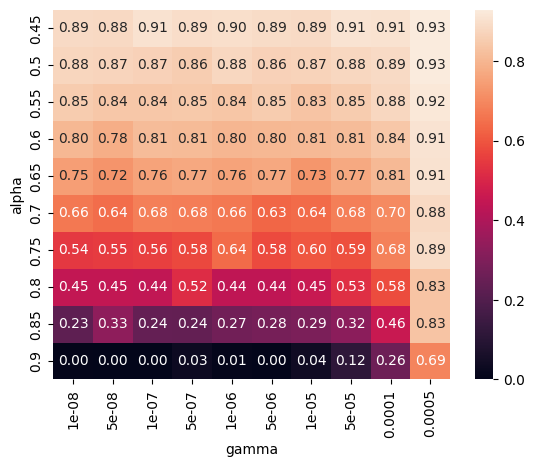

In [24]:
# Make Heatmap with alpha, gamma and human ratio
import seaborn as sns

data_pivot = data.pivot(index='alpha', columns='gamma', values='human_ratio')
sns.heatmap(data_pivot, annot=True, fmt=".2f")
plt.show()